<a href="https://colab.research.google.com/github/BatelCohen7/Diamonds/blob/main/Diamonds_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances


# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


# For validation
from sklearn.model_selection import train_test_split as split

# The data

We need to predict the price of diamonds (based on the dataset `diamonds.csv`), and we are measured by the RMSLE.

## Get the data

In [ ]:
diamonds = pd.read_csv('diamonds.csv', index_col='#')
diamonds.sample(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
#,,,,,,,,,,
41236,0.39,Premium,E,VVS2,61.1,59.0,1207,4.74,4.68,2.88
52319,0.33,Premium,F,SI1,60.9,59.0,550,4.42,4.45,2.70
290,0.71,Premium,D,SI1,61.3,58.0,2797,5.73,5.75,3.52
51636,0.31,Ideal,G,VS2,62.4,54.0,544,4.36,4.39,2.73
17163,1.02,Ideal,E,VS2,62.7,56.0,6854,6.44,6.38,4.02


In [ ]:
diamonds.shape

(53940, 10)

> **Note:** This is a good place to have an exploratory data analysis of the data (EDA), but we will skip it for this session.

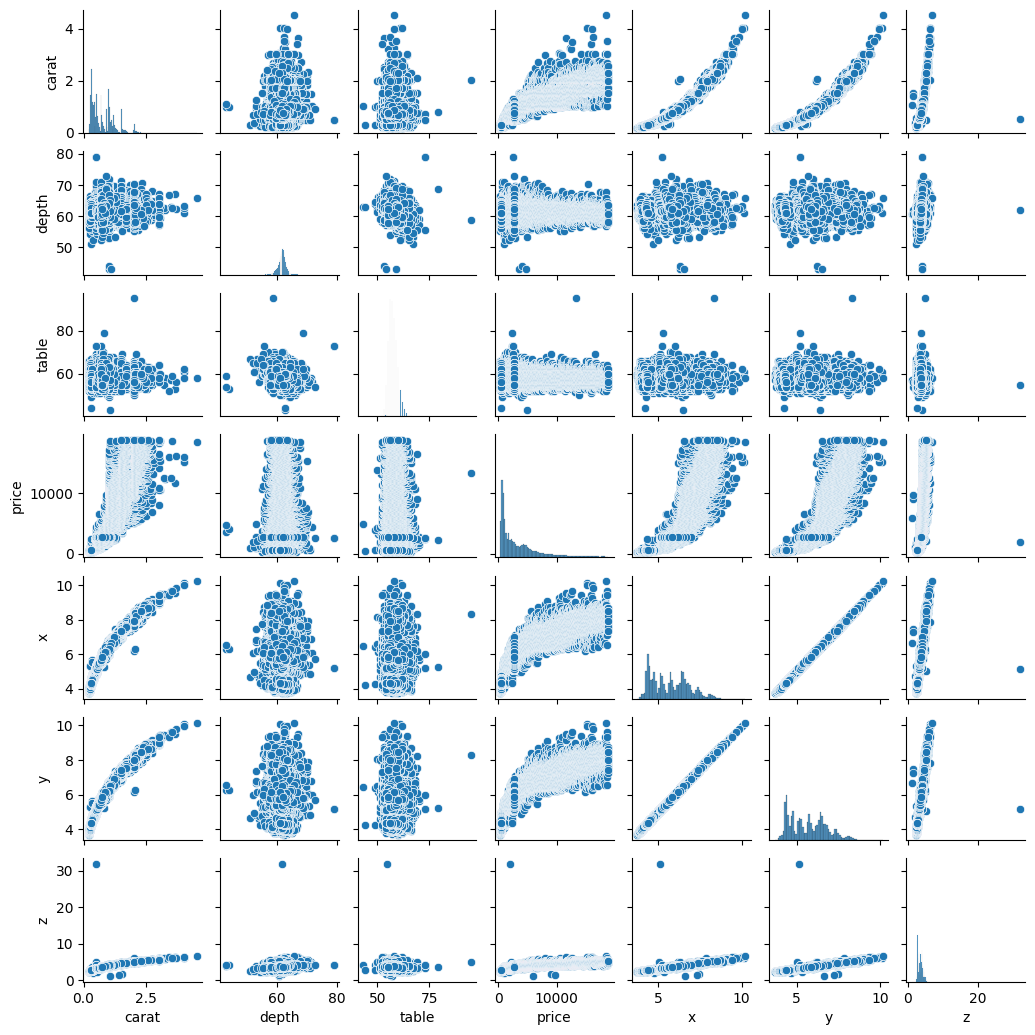

In [ ]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

> **Note:** As we progress with manipulating the data, we can come back to this visualization and see how the story unravels.

## Cleaning

This step makes sure only relevant data is collected.

### Dropping non-physical diamonds

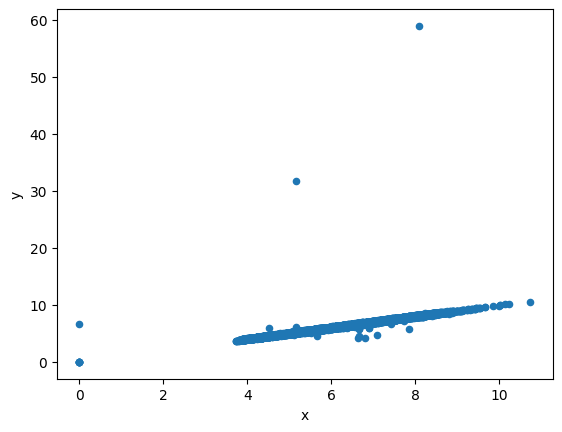

In [ ]:
diamonds.plot.scatter('x', 'y');

In [ ]:
def drop_zeros(df):
    return df.loc[df.x * df.y * df.z != 0]

In [ ]:
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)

In [ ]:
diamonds = zeros_dropper.fit_transform(diamonds)

In [ ]:
diamonds.shape

(53920, 10)

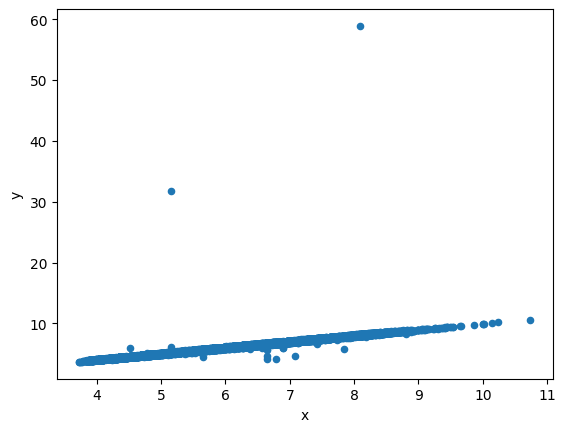

In [ ]:
diamonds.plot.scatter('x', 'y');

### Removing non-round diamonds

In [ ]:
def select_round(X, diff_max=0.1):
    return X.loc[(X.x - X.y).abs() < diff_max]

In [ ]:
cut_rounder = FunctionTransformer(select_round, validate=False, kw_args={'diff_max': 0.1})

In [ ]:
diamonds = cut_rounder.fit_transform(diamonds)

In [ ]:
diamonds.shape

(52004, 10)

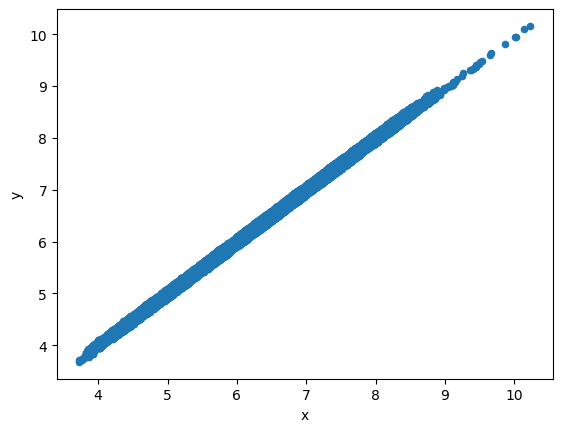

In [ ]:
diamonds.plot.scatter('x', 'y');

### Removing outliers

#### 6-sigma range

For illustration purposes we illustrate a simple and common outlier removing technique, based on keeping the values between 3 times the standard deviation. Many times it is advisable to apply a more robust process.

In [1]:
for col in diamonds.columns:
    if diamonds[col].dtype == 'float64':
        std = diamonds[col].std()
        ave = diamonds[col].mean()
        diamonds = diamonds.loc[diamonds[col].between(ave-3*std, ave+3*std)]
        print(f'processing {col:10} --> {diamonds.shape[0]:5} diamonds remain')

NameError: name 'diamonds' is not defined

In [ ]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

#### Questionable data

Very often some of the data simply doesn't make sense. If you are lucky to have a domain expert, they will explain how it got there, but for your model it is better without such data samples. In our case we've noticed some bizzare `z`-values, when compared to `x` and `y`.

In [ ]:
sns.scatterplot(x='x', y='z', data=diamonds);

The problematic data points can be removed manually, but...

In [ ]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a+b*x

(a,b), _ = curve_fit(line, diamonds.x, diamonds.z)

eps = 0.35
diamonds.x.apply(line, a=a, b=b)
diamonds = diamonds.loc[~((diamonds.x.apply(line, a=a, b=b)-diamonds.z).abs() > eps),:]

In [ ]:
diamonds.plot.scatter(x='x',y='z');

> **Discussion:** How do we choose $\epsilon$? Should it be tight or loose?

> **Note:** These outliers can be easily removed manually, however there are other methods for anomaly detection, e.g. LOF (by neighbors) and isolation forest (by trees).

In [ ]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

> **Discussion:** In the next steps we manipulate the data to make it as suitable as possible for our chosen models. What does it mean "suitable" and why it may be different for different models?

> **Note:** Nothing tells us when we need to stop cleaning...

## Feature Selection

For many practical reasons, and also due to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning), it is always a good idea to reduce the number of features. One of the methods of doing that is by removing features completely.

In [ ]:
diamonds.sample(5)

### Relevance

Very often, some of the features are irrelevant for the problem and can be removed. This is by far the most important aspect of dimensionality reduction.

Other methods involve statistics in order to score the relevancy of some features (e.g. [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)).

### Correlation

Many times columns are closely related to other columns and therefore can be dropped. This is usually more relevant to numerical data, so we use [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html).

> **Warning:** Most of the time, when people talk about correlation between features they talk about **linear correlation**.

It is clear that `x`, `y` and `z` are highly linearly correlated, and this can be confirmed by evaluating the linear correlation between them using the [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method. This is usually visualized using a heat map.

In [ ]:
diamonds.select_dtypes('number').corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.013970,0.186483,0.923555,0.981895,0.981381,0.980922
depth,0.013970,1.000000,-0.277449,-0.016804,-0.031025,-0.032787,0.076980
table,0.186483,-0.277449,1.000000,0.134039,0.192133,0.187753,0.160208
price,0.923555,-0.016804,0.134039,1.000000,0.885301,0.886269,0.881525
x,0.981895,-0.031025,0.192133,0.885301,1.000000,0.999102,0.993721
y,0.981381,-0.032787,0.187753,0.886269,0.999102,1.000000,0.993523
z,0.980922,0.076980,0.160208,0.881525,0.993721,0.993523,1.000000


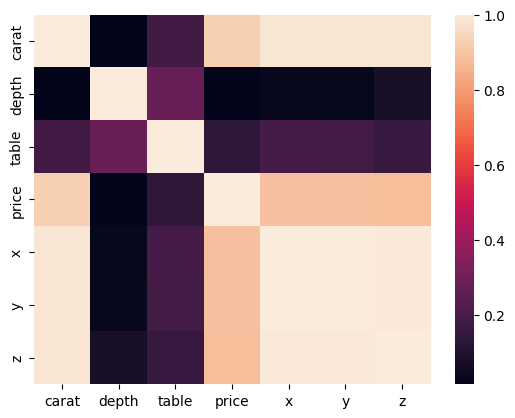

In [ ]:
sns.heatmap(diamonds.select_dtypes('number').corr().abs());

Due to the high correlation we decide to drop all dimensions besides the `carat`.

In [ ]:
diamonds.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price
#,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326
2,0.21,Premium,E,SI1,59.8,61.0,326
4,0.29,Premium,I,VS2,62.4,58.0,334
5,0.31,Good,J,SI2,63.3,58.0,335
6,0.24,Very Good,J,VVS2,62.8,57.0,336


## Preprocessing

In [ ]:
diamonds.shape

(50511, 7)

### Scaling

#### Features

For many reasons, it is often advisable to scale the features. One of the reasons is to make sure that none of the featrues "shadows" the others.

Based on [This diamonds explanation](https://rstudio-pubs-static.s3.amazonaws.com/316651_5c92e58ef8a343e4b3f618a7b415e2ad.html), we know that `depth` and `table` actually represent ratios, so we can simply divide them by $100$.

In [ ]:
diamonds[['depth', 'table']] = diamonds[['depth', 'table']] / 100

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price
#,,,,,,,
1,0.23,Ideal,E,SI2,0.615,0.55,326
2,0.21,Premium,E,SI1,0.598,0.61,326
4,0.29,Premium,I,VS2,0.624,0.58,334
5,0.31,Good,J,SI2,0.633,0.58,335
6,0.24,Very Good,J,VVS2,0.628,0.57,336


#### Target

<Axes: >

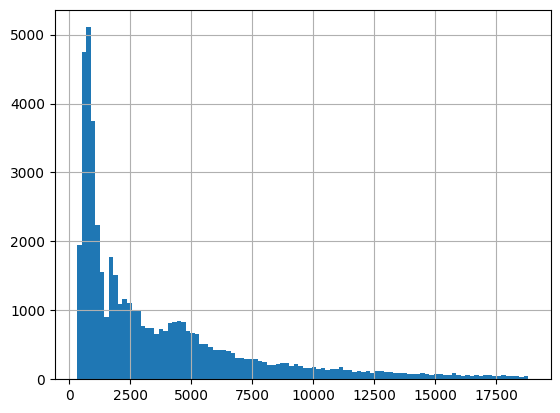

In [ ]:
diamonds.price.hist(bins=100)

Also, it is easier for most models to predict a more regular target, so we can apply any "reversible" transformation and predict the transformed values. Just don't forget to transform it back...

In our case, the target distribution (`price`) has a long tail at the high values, so we can apply the log transformation, conveniently implemented by [`np.log1p()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html).

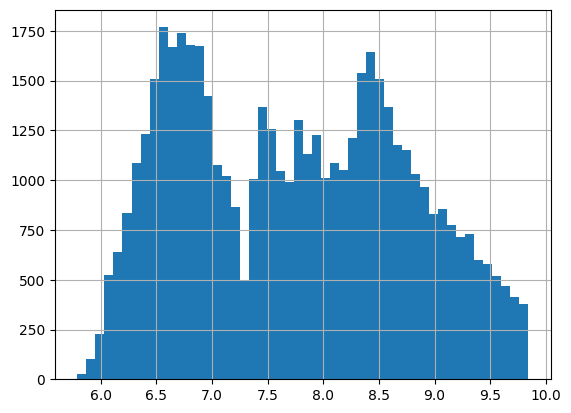

In [ ]:
log_price = np.log1p(diamonds.price)
log_price.hist(bins=50);

In [ ]:
diamonds['price'] = log_price
diamonds.rename({'price': 'log_price'}, inplace=True, axis=1)

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,log_price
#,,,,,,,
1,0.23,Ideal,E,SI2,0.615,0.55,5.789960
2,0.21,Premium,E,SI1,0.598,0.61,5.789960
4,0.29,Premium,I,VS2,0.624,0.58,5.814131
5,0.31,Good,J,SI2,0.633,0.58,5.817111
6,0.24,Very Good,J,VVS2,0.628,0.57,5.820083


> **Discussion:** We have to remind ourselves how we are scored. We can either "turn the wheel" before evaluating the final score on the predictions in the original scale, or we need to change the score function as well. For example, consider two alternatives for the diamonds dataset - in one you don't scale and score with RMSLE, and in the second you scale and score with RMSE. What is the differnce between these two approaches?

> **Note:** We note specifically that the RMSE of the `log_price` predictions is equivalent to the RMSLE of the `price` predictions.

> **Reference:** For a more comprehensive overview of regression metrics, see [A Comprehensive Introduction to Evaluating Regression Models](https://www.analyticsvidhya.com/blog/2021/10/evaluation-metric-for-regression-models/) from Analytics Vidhya.

### Categorical data

All models expect numerical input, therefore it is mandatory to transform the categorical data into numerical data. There are several technique to do that, however the method should be selected on the context of the entire pipeline.

For simplicity we will use the most simple manipulation, assigning an *ordinal* number to each category.

In [ ]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_map = dict(zip(cut_order, range(len(cut_order))))

color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
color_map = dict(zip(color_order, range(len(color_order))))

clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
clarity_map = dict(zip(clarity_order, range(len(clarity_order))))

In [ ]:
diamonds['cut'] = diamonds['cut'].map(cut_map)
diamonds['color'] = diamonds['color'].map(color_map)
diamonds['clarity'] = diamonds['clarity'].map(clarity_map)

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,log_price
#,,,,,,,
1,0.23,4,5,1,0.615,0.55,5.789960
2,0.21,3,5,2,0.598,0.61,5.789960
4,0.29,3,1,3,0.624,0.58,5.814131
5,0.31,1,0,1,0.633,0.58,5.817111
6,0.24,2,0,5,0.628,0.57,5.820083


In [ ]:
diamonds.shape

(50511, 7)

> **Discussion:** As we will see later, this (too common) enumeration method is rarely appropriate, and you should be careful if and when applying it. What are the problems with this conversion? What other ideas can be used?

## Splitting the data

For validation purposes we split the data. It is a common convention that the features are denoted by $X$ and the target is denoted by $y$.

In [ ]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

The *train* part is used for training the model, and the *test* part is used for validation.

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

In [ ]:
X_train.head(3)

,carat,cut,color,clarity,depth,table
#,,,,,,
9407,1.00,3,4,2,0.629,0.57
14523,1.00,1,4,3,0.640,0.59
32006,0.41,4,0,7,0.621,0.54


In [ ]:
y_train.head(3)

#
9407     8.430981
14523    8.676758
32006    6.656727
Name: log_price, dtype: float64

# Linear regression

> **Reference:** [Linear regression explanation video by StatQuest](https://www.youtube.com/watch?v=7ArmBVF2dCs)

## Fitting the model

First we create the model

In [ ]:
lin_model_1 = LinearRegression(fit_intercept=False)

Then we **fit** it...

In [ ]:
lin_model_1.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

> **Note:** This is where the "magic" is happening, but it will be meaningless without the surrounding pipeline.

Now we can inspect the model...

In [ ]:
lin_model_1.intercept_

0.0

In [ ]:
list(zip(X_train.columns, lin_model_1.coef_))

[('carat', 2.3238675082630307),
 ('cut', 0.05763824060406364),
 ('color', 0.08867025459698902),
 ('clarity', 0.09499920281062607),
 ('depth', 5.599446058731549),
 ('table', 3.014933506023183)]

> **Discussion:** The coeffiecients are the prices of a column "unit". What does it mean for the various features? Was our preprocessing useful?

## Predicting with the model

In [ ]:
y_train_pred = lin_model_1.predict(X_train)

### Evaluating the model

In [ ]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

,Predictions,Actual
0,8.282025,8.430981
1,8.383641,8.676758
2,6.953653,6.656727
3,8.410515,8.537976
4,9.488350,9.104424
...,...,...
35352,10.068928,9.500320
35353,6.534918,6.196444
35354,6.821792,6.349139
35355,6.493813,6.035481


We use the *Predicted vs. Actual* visualization, where the red line stands for a "Perfect" prediction model.

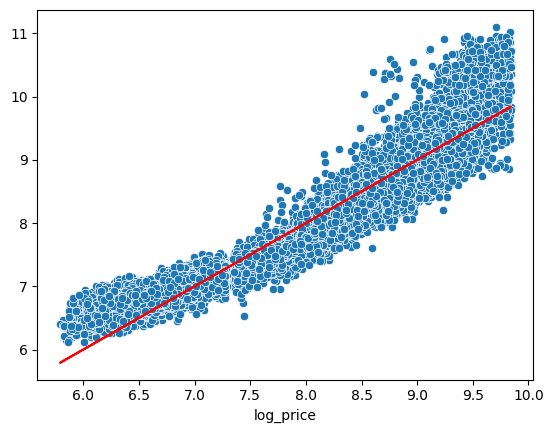

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

Finally, we can score our model

In [ ]:
mse(y_train, y_train_pred, squared=False)

0.3143410466301514

> **Discussion:** How can we tell whether this is a good result? Consider the available *benchmark*.

### Validating the model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = lin_model_1.predict(X_test)

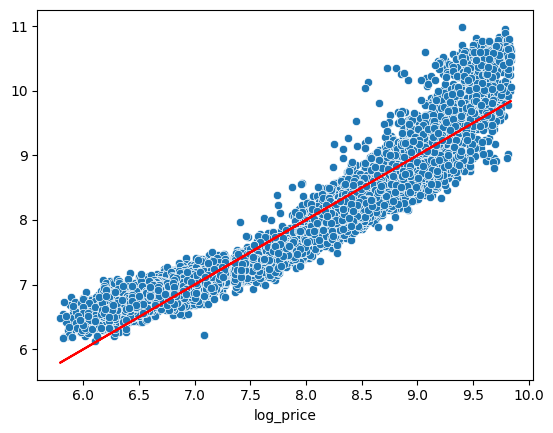

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [ ]:
RMSLE = mse(y_test, y_test_pred, squared=False)
RMSLE

0.3139313777658163

The test score is very close to the train score, therefore **the model is valid!**

> **Discussion:** We will not dive any deeper with the linear model, but there are some issues that should be discussed at this point:
* The linearity assumption
    * The interpretation of the coefficients is very strict. A feature which does not comply with it will harm the model.
    * The linear model is very limited, and is rarely used in practice for complex regressions.
* Interpretation of categorical features
    * The linearity of the model interprets the encoding of the categories as linear, which may be far from reality.
    * The problem can get even worse when the categories are not ordered, then **dummy variables** can be used.
* Error analysis
    * Very often the errors of a model come from a specific "systematic" problem, which can simplify things when discovered.
    * Consider `sns.boxplot(x=X_train.clarity, y=y_train-y_train_pred)`
* Feature engineering
    * `table` and `depth` are already such features...
    * What about interaction features (e.g. the simple [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer)?
* Regularization
    * The linear model has a `fit_intercept` hyperparameter.
    * There are 3 standard regularization methods for linear regression: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) & [Elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which is a combination of both.
    * They are less intuitive from other regularization methods, so we skip them for now.

# Decision Trees

> **Reference:** [Decision trees explanation video by StatQuest](https://www.youtube.com/watch?v=_L39rN6gz7Y)

## First shot

### Fit the model

In [ ]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

In [ ]:
dt_model_1 = DecisionTreeRegressor()
dt_model_1.fit(X_train, y_train)

DecisionTreeRegressor()

### Inspect the model

We write a small function to help us visualize the trees.

In [ ]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True,
            fontsize=12);

In [ ]:
X_train.head()

,carat,cut,color,clarity,depth,table
#,,,,,,
18920,1.07,2,5,4,0.620,0.60
126,0.70,3,4,3,0.616,0.60
24612,2.11,2,1,1,0.638,0.54
4828,0.90,3,4,1,0.614,0.62
22958,1.50,3,1,5,0.614,0.58


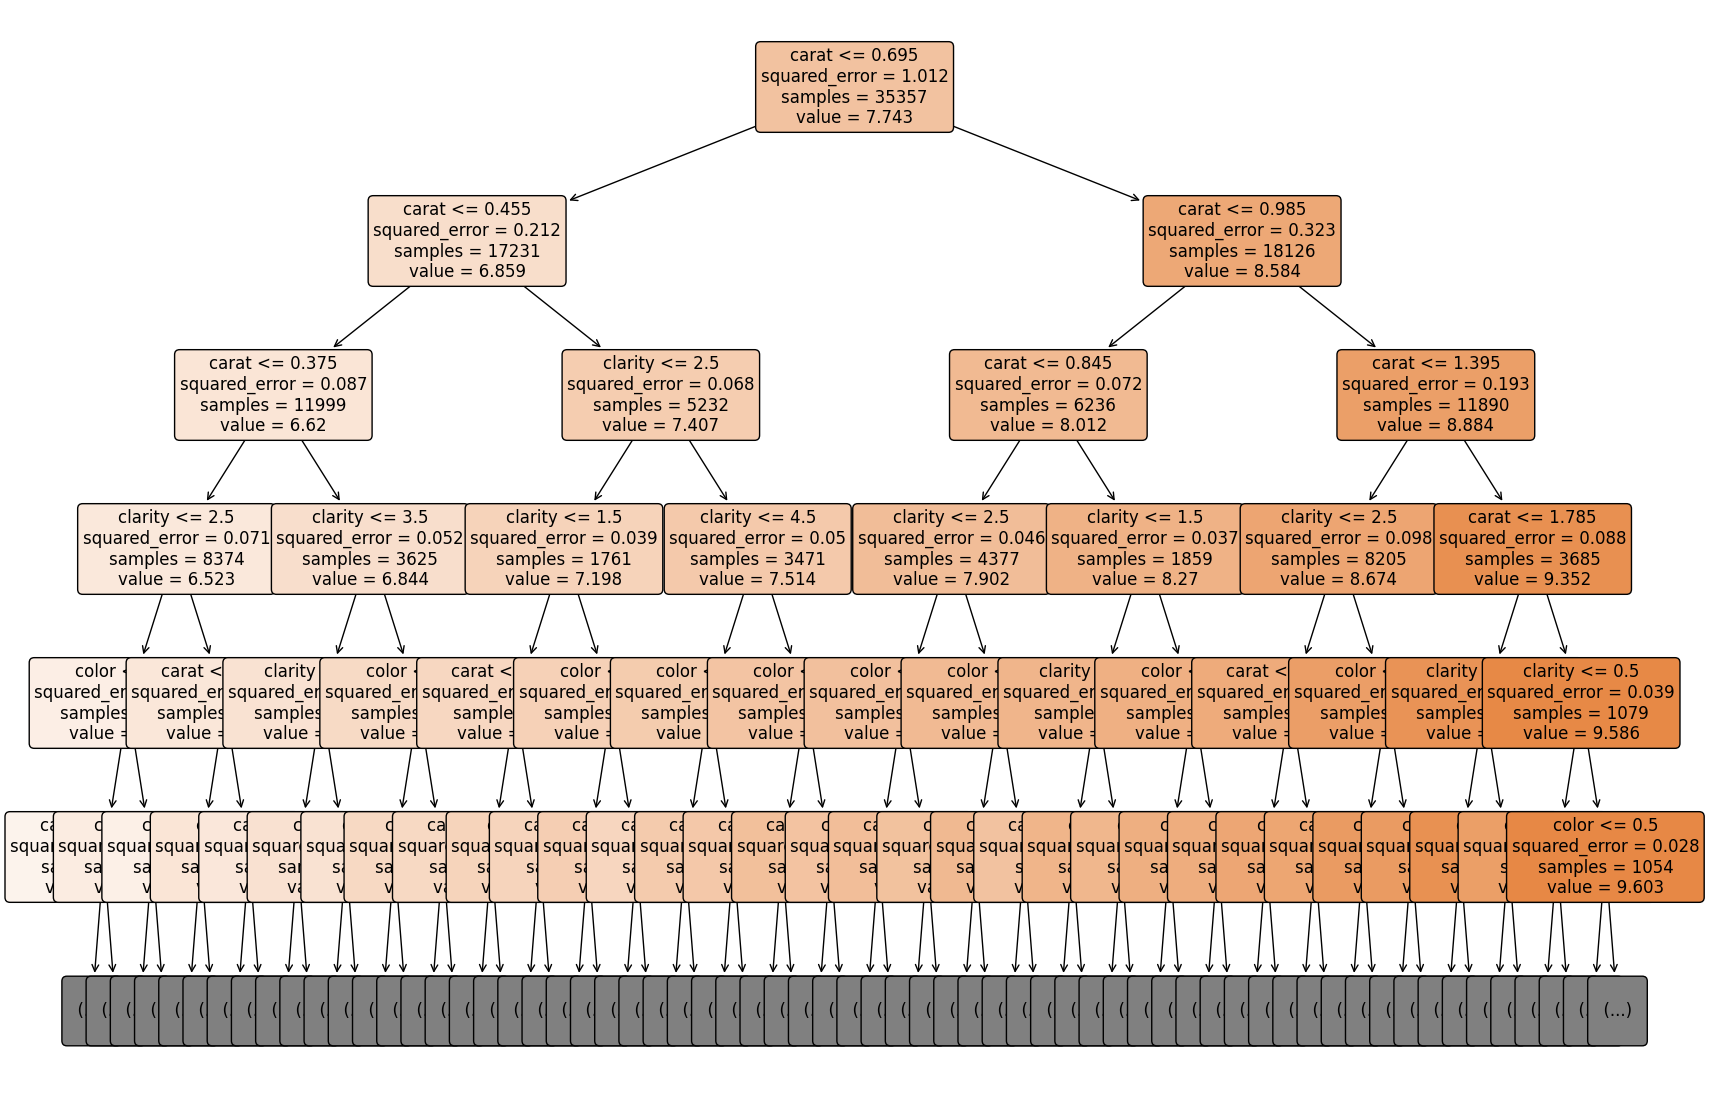

In [ ]:
visualize_tree(dt_model_1, md=5, fs=(20, 14))

> **Note:** The default hyper-parameters are set to overfitting, therefore the tree is enormous, so we cut the tree in the figure.

### Predicting with the model

In [ ]:
y_train_pred = dt_model_1.predict(X_train)

#### Evaluating the model

In [ ]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

,Predictions,Actual
0,8.957897,8.957897
1,7.924072,7.924072
2,9.467924,9.467924
3,8.217439,8.217439
4,9.306378,9.306378
...,...,...
35352,8.250098,8.250098
35353,6.214608,6.214608
35354,9.617537,9.617537
35355,7.119774,7.142827


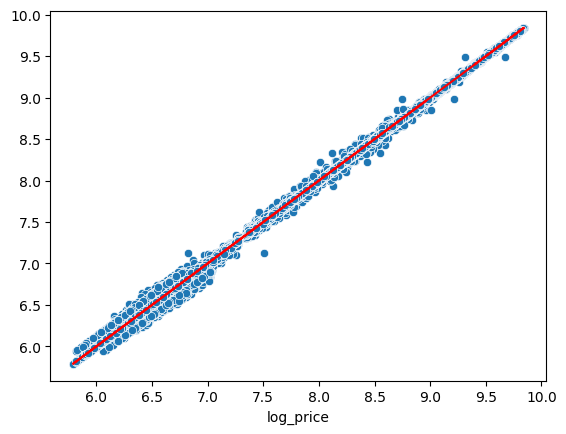

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [ ]:
RMSLE = mse(y_train, y_train_pred)**0.5
RMSLE

0.03882956044955878

**OMG!!!** This is an amazing result! What are we missing?

> **Discussion:** Why $RMSLE \neq 0$?

#### Validating the model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = dt_model_1.predict(X_test)

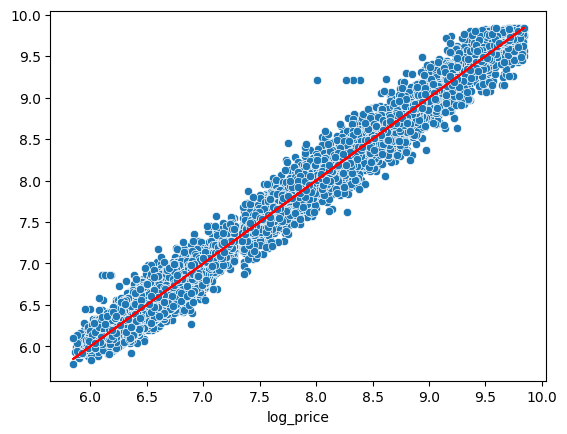

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [ ]:
RMSLE = mse(y_test, y_test_pred)**0.5
RMSLE

0.13723426844067088

> **Conclusion:** The model is overfitted.

## Overfitting

The fact that the **test error** is much worse than the **train error** is called [overfitting](https://en.wikipedia.org/wiki/Overfitting). It indicates that the model learned the train data too well, and now it cannot generalize well enough for new data.

> **Reference:**
> * [Nice intuition for overfitting by Divya Sharma](https://qr.ae/p1KiFJ) on Quora
> * [Collection of real-life overfitting examples](https://stats.stackexchange.com/questions/128616/whats-a-real-world-example-of-overfitting)

In [ ]:
sub_diamonds = diamonds.sample(1000)
sub_X = sub_diamonds.drop('log_price', axis=1)
sub_y = sub_diamonds.log_price
sub_X_train, sub_X_test, sub_y_train, sub_y_test = split(sub_X, sub_y, random_state=1415)

For this example we will look what happens to the train error and test error when we tune the hyper-parameter called `max_leaf_nodes`.

In [ ]:
complexity = range(2, 201 , 1)
scores = pd.DataFrame(index=complexity, columns=['train', 'test'])

for leafs in complexity:
    model = DecisionTreeRegressor(max_leaf_nodes=leafs).fit(sub_X_train, sub_y_train)

    sub_y_train_pred = model.predict(sub_X_train)
    scores.loc[leafs, 'train'] = mse(sub_y_train_pred, sub_y_train) ** 0.5

    sub_y_test_pred = model.predict(sub_X_test)
    scores.loc[leafs, 'test'] = mse(sub_y_test_pred, sub_y_test) ** 0.5

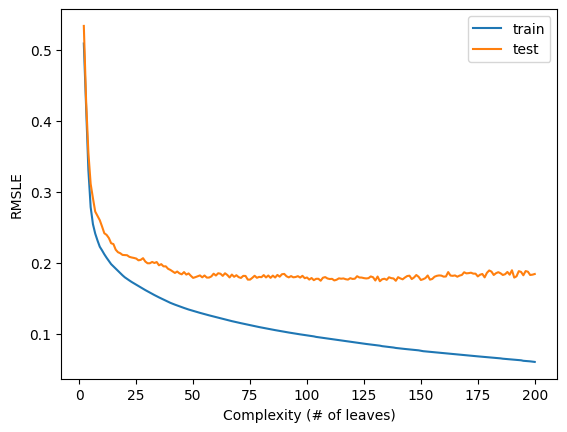

In [ ]:
scores.plot(xlabel='Complexity (# of leaves)', ylabel='RMSLE');

> **Discussion:** Discuss the graph. Note that the effect of overfitting is more critical when the data is more diverse and noisy. The diamonds dataset is not detailed enough for this issue to be observable.

There are several methods for dealing with overfitting, including dimensionality reduction, regularization and ensemble models. Decision trees are known for having many regularization hyper-parameters, and for our next model we explore them in order to have a more regular model.

> **Discussion:** What is it that we are looking for? How are we going to know if the model is overfitted or not?

> **Warning:** *Identifying* overfitting and *dealing* with overfitting are two separate tasks. The first is performed with **cross validation** and it will be covered separately.

> **Reference:** [More about overfitting by Machine Learning Mastery](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/)

## Second model

To avoid overfitting we will now experiment with **regularization**.

### Fit the model

Next we take some of the regularization **hyperparameters** and add constraints to the tree.

> **Reference:** The [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class

In [ ]:
dt_model_2 = DecisionTreeRegressor(min_samples_leaf=50, max_leaf_nodes=150)

In [ ]:
dt_model_2.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=150, min_samples_leaf=50)

### Inspect the model

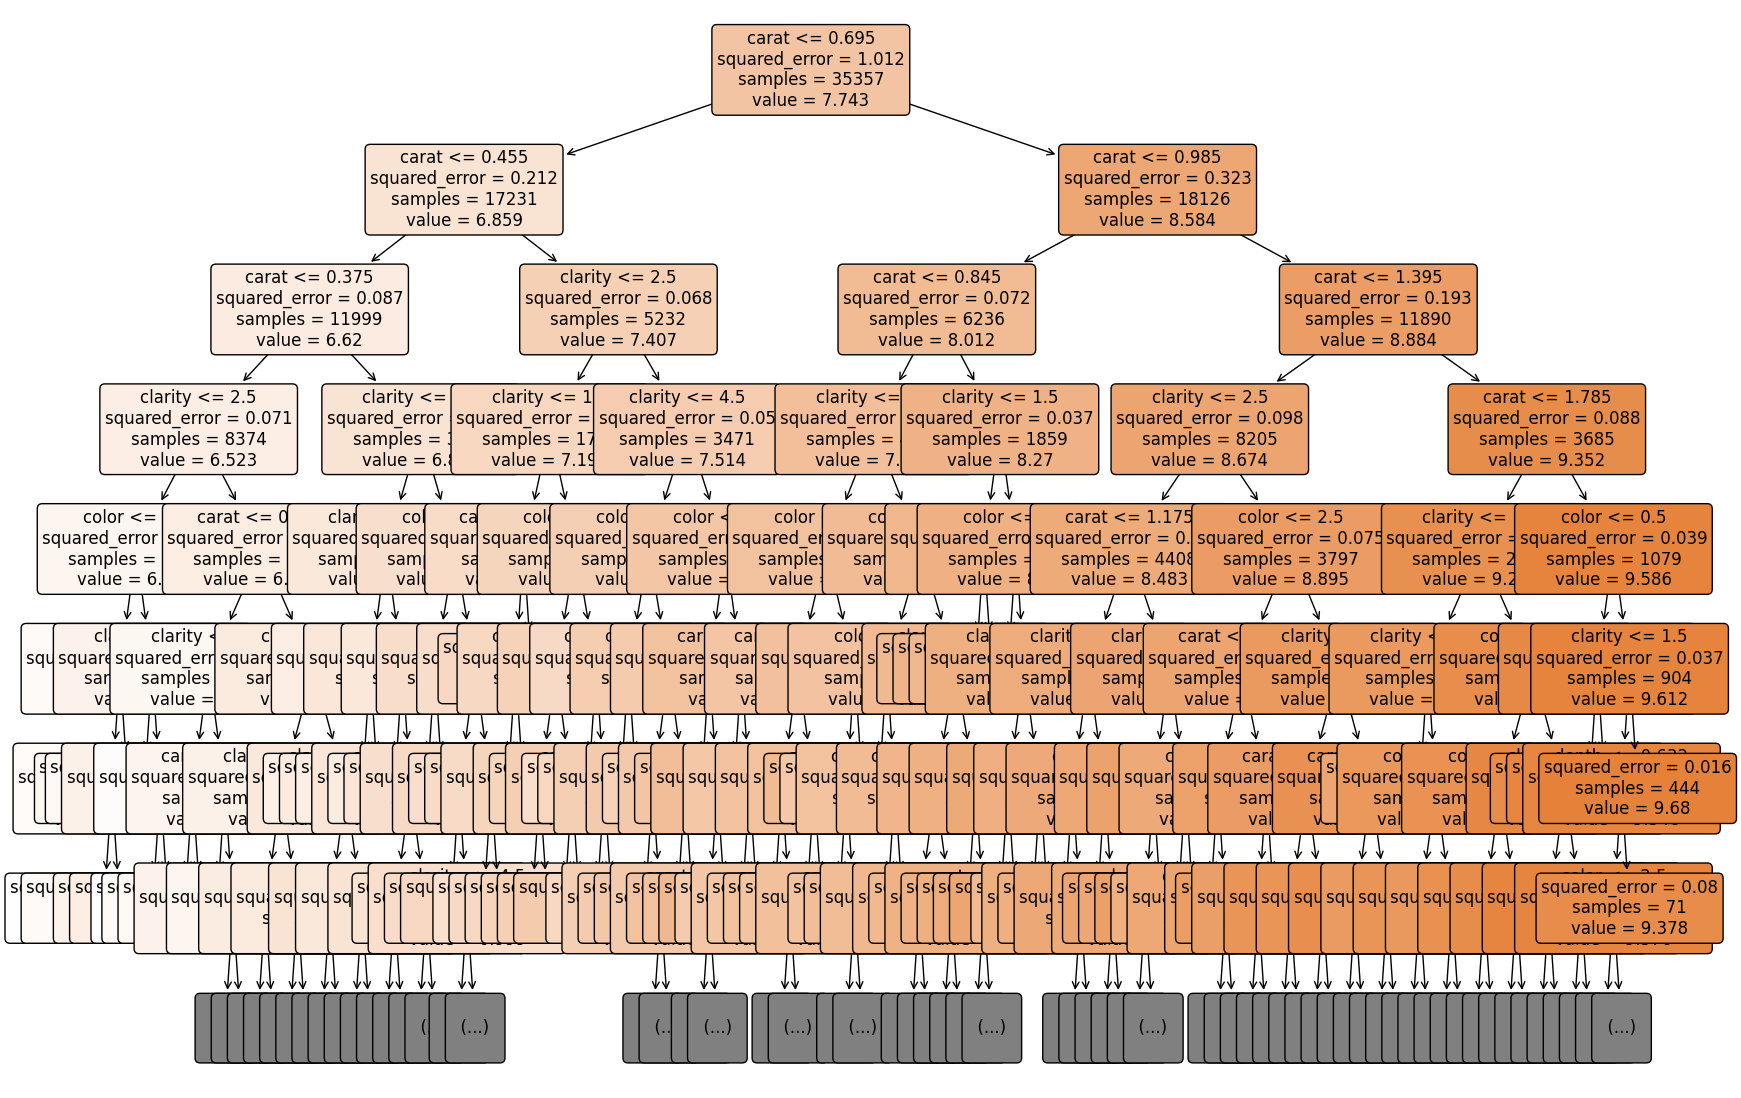

In [ ]:
visualize_tree(dt_model_2, md=7, fs=(20, 14))

> **Discussion:** Look at the entire tree and discuss whether it is overfitted or not.

### Predicting with the model

In [ ]:
y_train_pred = dt_model_2.predict(X_train)

In [ ]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

,Predictions,Actual
0,8.963494,8.957897
1,7.958676,7.924072
2,9.377592,9.467924
3,8.203389,8.217439
4,9.195480,9.306378
...,...,...
35352,8.217124,8.250098
35353,6.248684,6.214608
35354,9.680473,9.617537
35355,6.958687,7.142827


#### Evaluating the model

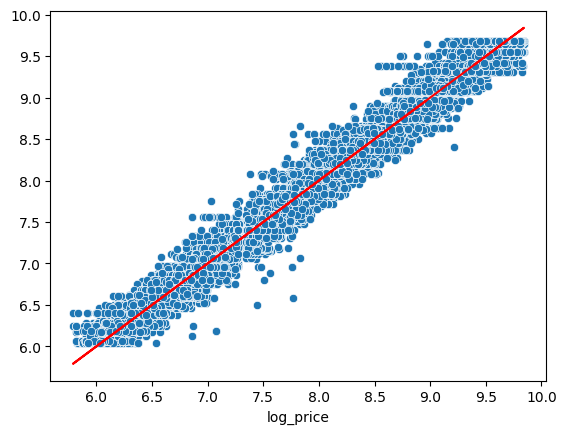

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [ ]:
RMSLE = mse(y_train, y_train_pred)**0.5
RMSLE

0.1291360786352178

#### Validating the model

In [ ]:
y_test_pred = dt_model_2.predict(X_test)

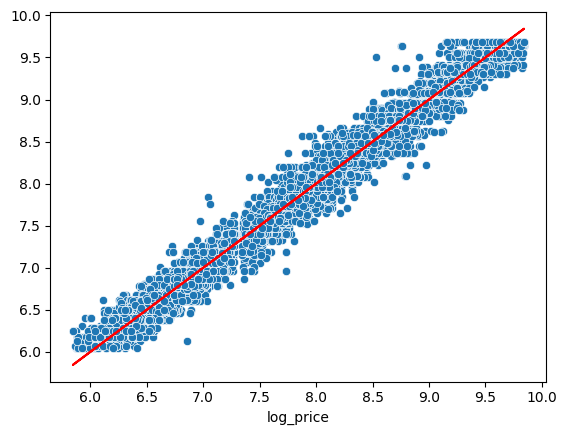

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSLE = mse(y_test, y_test_pred)**0.5
RMSLE

0.13242947927459617

Our model is now valid.

> **Discussion:** Consider again the `log1p` scaling of `price` in view of the MSE criterion.

## Explainability

### Feature importance

> **Reference:** [Feature importance overview by Machine Learning Mastery](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

Another useful inspection of a model is to look at the "importance" it corresponds to each feature. This can have many meanings, but for tree-based models it represents the relative accumulated success contributed by each feature.

In [ ]:
pd.Series(dt_model_2.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)#.plot.bar()

carat      0.955932
clarity    0.029594
color      0.014024
cut        0.000383
depth      0.000067
table      0.000000
dtype: float64

> **Reference:** Another common (and more general) method of evaluating the importance of each feature is [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/)

# K-Nearest Neighbors

> **Reference:** [K-NN explanation by StatQuest](https://www.youtube.com/watch?v=HVXime0nQeI)

## First shot

In [ ]:
X_train.head(5)

,carat,cut,color,clarity,depth,table
#,,,,,,
18920,1.07,2,5,4,0.620,0.60
126,0.70,3,4,3,0.616,0.60
24612,2.11,2,1,1,0.638,0.54
4828,0.90,3,4,1,0.614,0.62
22958,1.50,3,1,5,0.614,0.58


In [ ]:
knn_model_1 = KNeighborsRegressor(n_neighbors=10, )
knn_model_1.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

### Predicting with the model

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

In [ ]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

,Predictions,Actual
0,8.969318,8.957897
1,7.894705,7.924072
2,9.508749,9.467924
3,8.157247,8.217439
4,9.253410,9.306378
...,...,...
35352,8.202398,8.250098
35353,6.367024,6.214608
35354,9.688303,9.617537
35355,7.134210,7.142827


#### Evaluating the model

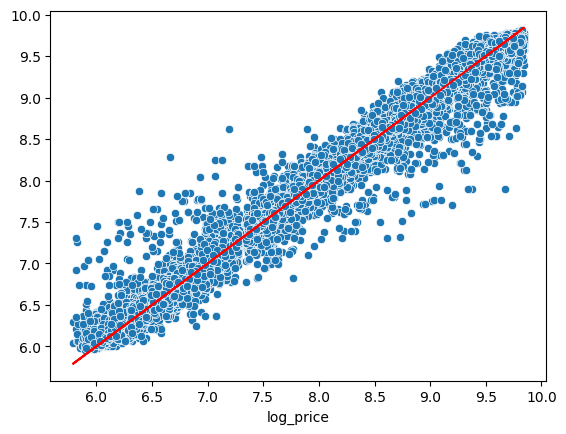

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.13157641176047605

#### Validating the model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = knn_model_1.predict(X_test)

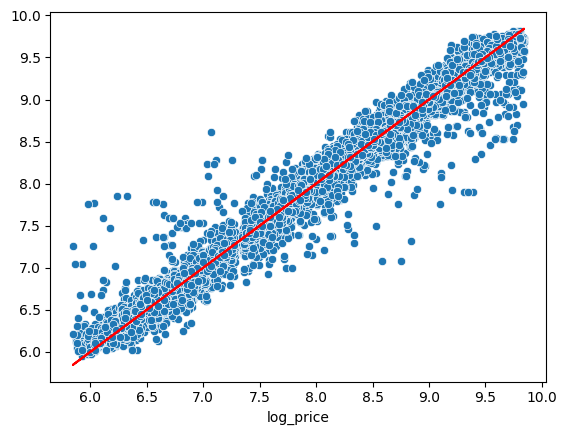

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [ ]:
RMSLE = mse(y_test, y_test_pred)**0.5
RMSLE

0.1479109393538001

## Second model

> **Reference:** The concept of *distance metric* is very important for defining the neighbors. Here you can find the [Most popular distance metrics by KDnuggets](https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html)

### Scaling the data

It is very useful to have the entire data on the same scale, and this is usually achieved with some scaling. One can scale the data in many ways, however Scikit-learn offers 3 simple scalers: [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) & [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Which one of them is the most relevant is a tricky question, and is usually rather intuitive from the nature of the feature.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

In [ ]:
X_train.head()

,carat,cut,color,clarity,depth,table
#,,,,,,
18920,1.07,2,5,4,0.620,0.60
126,0.70,3,4,3,0.616,0.60
24612,2.11,2,1,1,0.638,0.54
4828,0.90,3,4,1,0.614,0.62
22958,1.50,3,1,5,0.614,0.58


The default metric is the Euclidean one. This means that the categorical data has much more influence.
We have two options to deal with this situation - scaling our data or modifying the metric (or both).

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,carat,cut,color,clarity,depth,table
0,0.490826,0.50,0.833333,0.571429,0.942249,0.944882
1,0.321101,0.75,0.666667,0.428571,0.936170,0.944882
2,0.967890,0.50,0.166667,0.142857,0.969605,0.850394
3,0.412844,0.75,0.666667,0.142857,0.933131,0.976378
4,0.688073,0.75,0.166667,0.714286,0.933131,0.913386


### Fit the model

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10)
knn_model_2.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=10)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

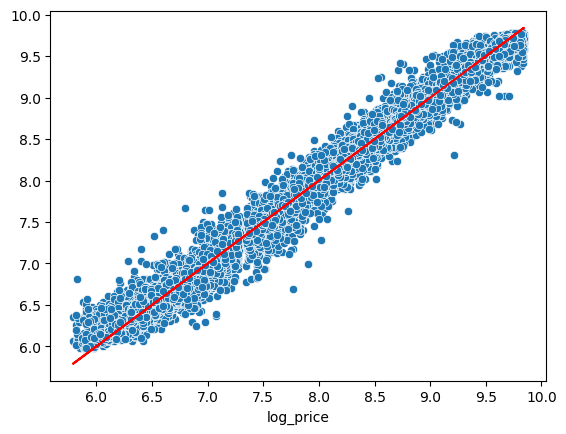

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [ ]:
RMSLE = mse(y_train, y_train_pred)**0.5
RMSLE

0.11225054686972102

### Validating the model

Let's see how does the model work for the test data...

In [ ]:
X_test_scaled = my_scaler.transform(X_test)

In [ ]:
y_test_pred = knn_model_2.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


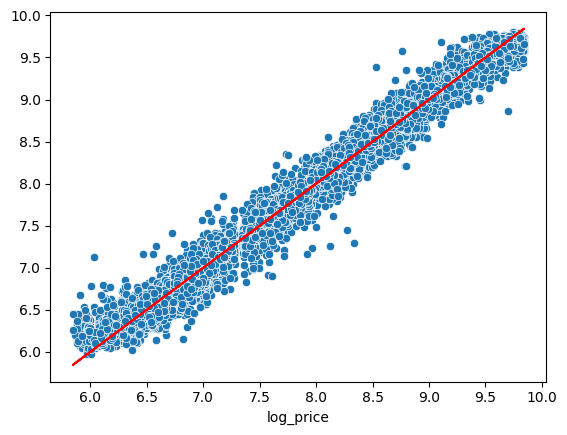

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [ ]:
RMSLE = mse(y_test, y_test_pred)**0.5
RMSLE

0.12405489317134036